# $\text{Damped Oscillation using PINNs}$

In [49]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

### $\text{Constants}$

In [50]:
y0 = 1    # initial position (m)
v0 = 0    # initial velocity (m/s)
m = 1     # mass (kg)
b = 3.5   # damping constant
k = 100   # spring constant

### $\text{Analytic Solution}$

In [51]:
def analytic_solution(t):
    wd = ((k/m) - (b/2*m)**2)**(0.5) # damped angular velocity
    gamma = b/(2*m)
    return y0 * torch.exp(-gamma*t) * torch.cos(wd*t)

### $\text{Initial and Training Time}$

In [52]:
t_initial = torch.tensor(0.0).view(-1, 1).requires_grad_(True)
t_train = torch.linspace(0, 3, 300).view(-1, 1).requires_grad_(True)

### $\text{Neural Networks Architecture}$

In [53]:
class NeuralNetworks(torch.nn.Module):
    def __init__(self, n_hidden):
        super(NeuralNetworks, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, n_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.net(x)

### $\text{Model Inisialization}$

In [54]:
model = NeuralNetworks(n_hidden=20)
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### $\text{Differential Function}$

In [55]:
def derivative(num, den):
    return torch.autograd.grad(num, den, torch.ones_like(num), create_graph=True)[0]

### $\text{Training}$

In [56]:
num_epochs = 5000
for epoch in range(num_epochs + 1):
    optimizer.zero_grad()

    # Calculate the loss of initial position
    y0_pred = model(t_initial)
    loss1 = (torch.squeeze(y0_pred) - y0)**2

    # Calculate the loss of initial velocity
    v0_pred = derivative(y0_pred, t_initial)
    loss2 = (torch.squeeze(v0_pred) - v0)**2

    # Calculate the loss of motion equation
    y = model(t_train)
    v = derivative(y, t_train)
    a = derivative(v, t_train)
    loss3 = torch.mean((m*a + b*v + k*y)**2)

    # Penalty for increase the accuracy of prediction
    penalty2 = 1e-2
    penalty3 = 1e-2

    # Calculate the total loss
    loss = loss1 + penalty2*loss2 + penalty3*loss3

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Logging
    if epoch % 200 == 0:
        print(f"Epoch: {epoch}/{num_epochs} ===> Loss: {loss.item():.6f}")

Epoch: 0/5000 ===> Loss: 3.476827
Epoch: 200/5000 ===> Loss: 0.763548
Epoch: 400/5000 ===> Loss: 0.611962
Epoch: 600/5000 ===> Loss: 0.219888
Epoch: 800/5000 ===> Loss: 0.235657
Epoch: 1000/5000 ===> Loss: 0.059519
Epoch: 1200/5000 ===> Loss: 0.033344
Epoch: 1400/5000 ===> Loss: 0.018988
Epoch: 1600/5000 ===> Loss: 0.018739
Epoch: 1800/5000 ===> Loss: 0.026128
Epoch: 2000/5000 ===> Loss: 0.018127
Epoch: 2200/5000 ===> Loss: 0.016391
Epoch: 2400/5000 ===> Loss: 0.017497
Epoch: 2600/5000 ===> Loss: 0.015619
Epoch: 2800/5000 ===> Loss: 0.015011
Epoch: 3000/5000 ===> Loss: 0.014784
Epoch: 3200/5000 ===> Loss: 0.013916
Epoch: 3400/5000 ===> Loss: 0.013897
Epoch: 3600/5000 ===> Loss: 0.016573
Epoch: 3800/5000 ===> Loss: 0.035832
Epoch: 4000/5000 ===> Loss: 0.017837
Epoch: 4200/5000 ===> Loss: 0.006167
Epoch: 4400/5000 ===> Loss: 0.005033
Epoch: 4600/5000 ===> Loss: 0.004667
Epoch: 4800/5000 ===> Loss: 0.010023
Epoch: 5000/5000 ===> Loss: 0.004141


### $\text{Evaluation using MSE}$

In [57]:
# Initialize the prediction and true array
y_pred = model(t_train).detach().numpy()
y_true = analytic_solution(t_train).detach().numpy()

# Calculate the MSE Loss
MSELoss = mean_squared_error(y_pred, y_true)

print(f"MSE Loss: {MSELoss*100:.4f} %")

MSE Loss: 0.1636 %


### $\text{Visualization}$

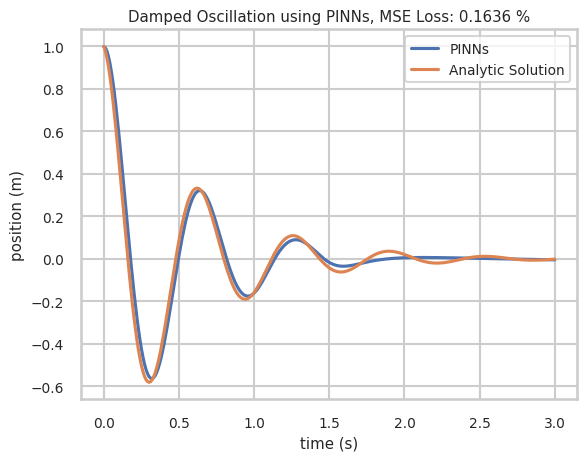

In [58]:
t = t_train.detach().numpy()

# Plotting
plt.plot(t, y_pred, label="PINNs")
plt.plot(t, y_true, label="Analytic Solution")
plt.title(f"Damped Oscillation using PINNs, MSE Loss: {MSELoss*100:.4f} %")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
plt.legend()
plt.grid(True)
plt.show()